In [3]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
from collections import defaultdict

In [8]:
class BasicConfig:
    """
    Defines a simple configuration class.
    """
    DATA_PATH = '/mnt/data1/romualdo_data/datasets/air-quality/processed'
    PLOT_DIR = '../../plots/notebooks'
    POLLUTANT_DIR = 'pollutants'
    TRANSITS_DIR = 'transits'
    WEATHER_DIR = 'weather'
    DATA_SET = 'data_merged.csv' 
    

In [5]:
def to_datetime(text):
    return np.datetime64(text)

# Load the dataset
The weather dataset right now contains every 

In [9]:
config = BasicConfig()

In [12]:
path = os.path.join(config.DATA_PATH, config.TRANSITS_DIR, config.DATA_SET)
data = pd.read_csv(path, index_col=0, parse_dates=True, date_parser=to_datetime)
data = data[sorted(data.columns.tolist())]
data = data.drop(columns=['na_euro','na_fuel', 'na_vehicle','other','other_vehicles'])
data.head()

authorized   bus  cargo  diesel  electric  euro0  euro1  \
timestamp                                                                      
2013-01-01 00:00:00       638.0  26.0   66.0  1186.0       0.0    1.0    9.0   
2013-01-01 01:00:00       894.0  31.0   70.0  1987.0       3.0    6.0   23.0   
2013-01-01 02:00:00       974.0  35.0   78.0  1828.0       0.0    1.0   26.0   
2013-01-01 03:00:00       884.0  34.0   77.0  1259.0       0.0    7.0   10.0   
2013-01-01 04:00:00       785.0  29.0   57.0   966.0       0.0    2.0    6.0   

                     euro2  euro3   euro4  ...  euro6    gas  hybrid  \
timestamp                                  ...                         
2013-01-01 00:00:00  177.0  434.0  1214.0  ...    0.0  203.0   132.0   
2013-01-01 01:00:00  308.0  726.0  2149.0  ...    1.0  340.0   178.0   
2013-01-01 02:00:00  255.0  699.0  2013.0  ...    3.0  319.0   195.0   
2013-01-01 03:00:00  186.0  420.0  1357.0  ...    2.0  221.0   151.0   
2013-01-01 04:00:00  138.0  294.0  1015.0  ...    0.0  158.0   128.0   

                     non_authorized  non_residents  people  petrol  residents  \
timestamp                                                                       
2013-01-01 00:00:00          2115.0         2518.0  2425.0  1007.0      235.0   
2013-01-01 01:00:00          3734.0         3894.0  4287.0  1905.0      734.0   
2013-01-01 02:00:00          3379.0         3762.0  3925.0  1720.0      591.0   
2013-01-01 03:00:00          2113.0         2622.0  2637.0  1128.0      375.0   
2013-01-01 04:00:00          1487.0         2083.0  1916.0   760.0      189.0   

                     service   total  
timestamp                             
2013-01-01 00:00:00     14.0  2753.0  
2013-01-01 01:00:00     17.0  4628.0  
2013-01-01 02:00:00     16.0  4353.0  
2013-01-01 03:00:00     18.0  2997.0  
2013-01-01 04:00:00     24.0  2272.0  

[5 rows x 21 columns]

## Plot sensors divided by type
Each weather feature has 1+ sensors associated, plot them together to see how much coverage we can get.

In [15]:
for col in data.columns:
    total = len(data)
    nans = data[col].isna().sum().sum()
    print(f"{col} & {nans}/{total} & {nans/float(total) * 100:.2f}\%  \\\\")

authorized & 0/606341376 & 0.00\%  \\
bus & 0/606341376 & 0.00\%  \\
cargo & 0/606341376 & 0.00\%  \\
diesel & 0/606341376 & 0.00\%  \\
electric & 0/606341376 & 0.00\%  \\
euro0 & 0/606341376 & 0.00\%  \\
euro1 & 0/606341376 & 0.00\%  \\
euro2 & 0/606341376 & 0.00\%  \\
euro3 & 0/606341376 & 0.00\%  \\
euro4 & 0/606341376 & 0.00\%  \\
euro5 & 0/606341376 & 0.00\%  \\
euro6 & 0/606341376 & 0.00\%  \\
gas & 0/606341376 & 0.00\%  \\
hybrid & 0/606341376 & 0.00\%  \\
non_authorized & 0/606341376 & 0.00\%  \\
non_residents & 0/606341376 & 0.00\%  \\
people & 0/606341376 & 0.00\%  \\
petrol & 0/606341376 & 0.00\%  \\
residents & 0/606341376 & 0.00\%  \\
service & 0/606341376 & 0.00\%  \\
total & 0/606341376 & 0.00\%  \\


In [14]:
for col in data.columns:
    f = plt.figure(figsize=(120, 10))
    plt.plot(data.index, data[col])
    plt.title(col)
    plt.tight_layout()
    plt.savefig(os.path.join(config.PLOT_DIR, config.TRANSITS_DIR, f"{col}.png"))
    plt.close(f)

## Correlation matrix plot
This demonstrates that we can average the sensor data by type, since most of them have a correlation ~1.  
Unfortunately wind direction is hopeless: even using sin and cos there's not much chance of recover and it's missing almost all 2013, so we will discard.


In [6]:
data2 = data.copy()
corr = data2.corr()
corr.style.background_gradient(cmap='coolwarm')

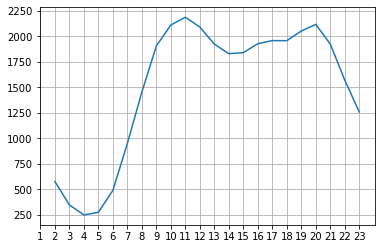

In [13]:
hourly = data.groupby(data.index.hour).mean()
hourly = hourly.mean(axis=1)
plt.xticks(np.arange(0, 24))
plt.grid(which="major")
plt.plot(hourly.index, hourly.rolling(3).mean())


Use average vehicle counts for each hour as a weight for interpolating PM

In [9]:
weights = hourly.rolling(3).mean().values / hourly.mean()
weights

array([       nan,        nan, 0.39443103, 0.23741165, 0.16983412,
       0.18748042, 0.33549721, 0.65214485, 0.99785621, 1.30901437,
       1.44976567, 1.50189919, 1.4358604 , 1.32036065, 1.25653023,
       1.26320114, 1.32364134, 1.3444966 , 1.34404836, 1.40920658,
       1.45381273, 1.3209662 , 1.07793764, 0.86349359])